# Convolutional Neural Networks
---

Prof. Dr.-Ing. Antje Muntzinger, Hochschule für Technik Stuttgart

antje.muntzinger@hft-stuttgart.de

---

This notebook is based on Udacity's *Deep Learning Nanodegree*.

In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='images/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [30]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [44]:
import os

# check if 'models' folder exists, if not, create it
if not os.path.exists('models'):
    os.makedirs('models')

**TODO:** Make sure you are training on GPU if you are training on a CUDA capable device. Otherwise, check your PyTorch installation!

---
## Load and Augment the [Data](https://pytorch.org/vision/main/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

#### Augmentation

In this cell, we perform some simple [data augmentation](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) by randomly flipping and rotating the given image data. We do this by defining a torchvision `transform`, and you can learn about all the transforms that are used to pre-process and augment data, [here](https://pytorch.org/vision/0.9/transforms.html).

This type of data augmentation should add some positional variety to these images, so that when we train a model on this data, it will be robust in the face of geometric changes (i.e. it will recognize a ship, no matter which direction it is facing). It's recommended that you choose one or two transforms.

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transforms)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train)) # np.floor() rounds down to the nearest integer
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

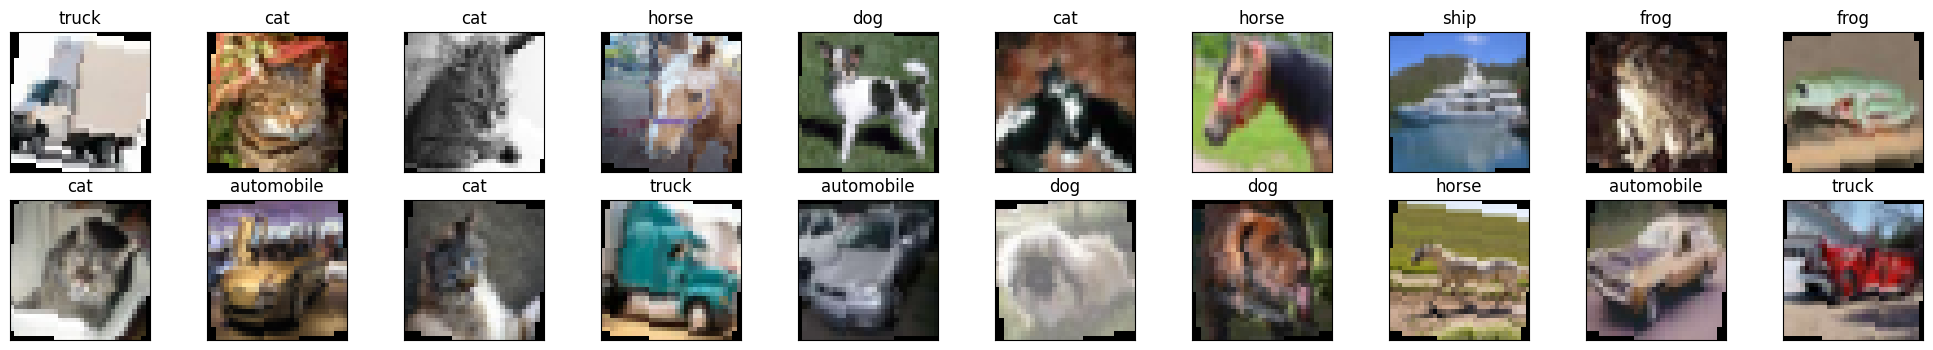

In [33]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

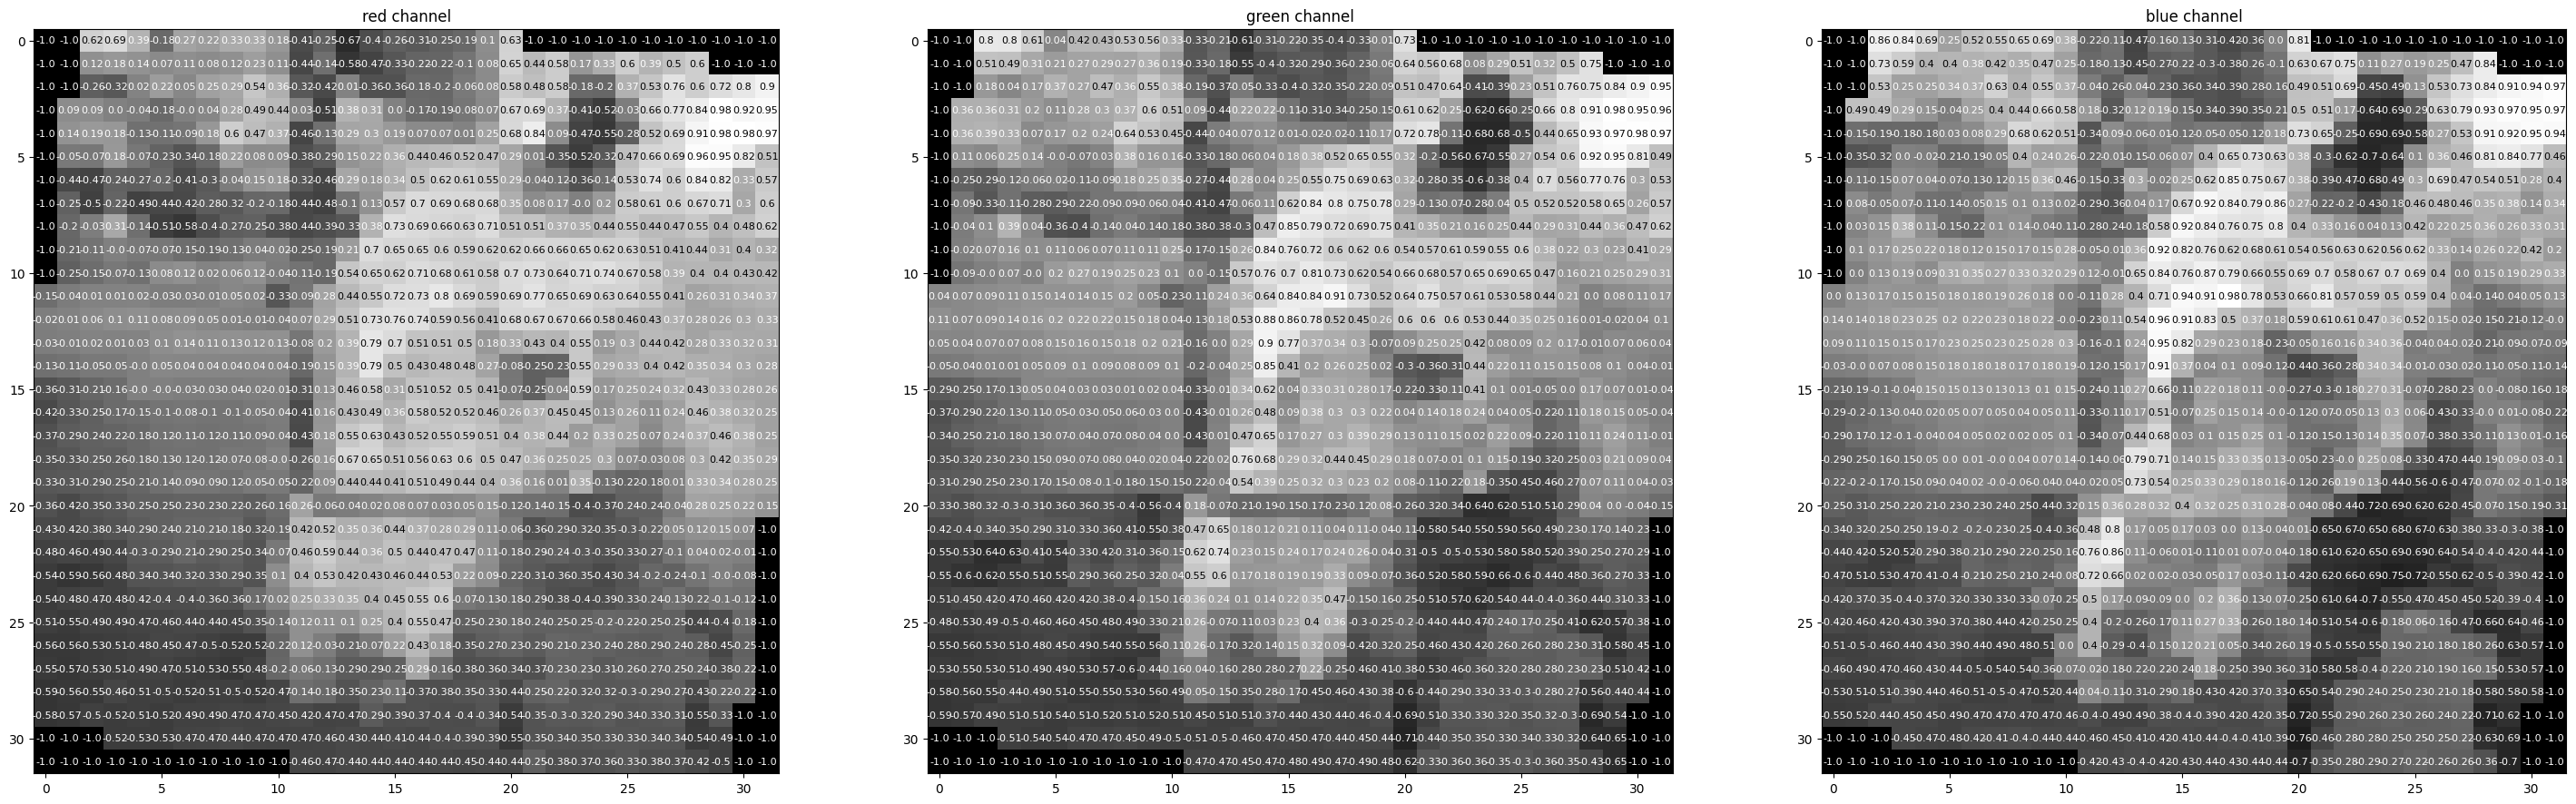

In [ ]:
rgb_img = np.squeeze(images[3]) # remove the batch dimension
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5 # set threshold for text color (black or white)
    # add text annotations to the image
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with two convolutional and two maxpooling layers.

<img src='images/2_layer_conv.png' height=50% width=50% />


#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and no padding (`padding=0`) we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [35]:
import torch.nn as nn
import torch.nn.functional as F     

# define the CNN architecture
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (32 * 8 * 8 -> 500)
        self.fc1 = nn.Linear(32 * 8 * 8, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = x.view(-1, 32 * 8 * 8)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model1 = Net1()
print(model1)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model1.cuda()

Net1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point or [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

**TODO:** Define the loss and optimizer and see how these choices change the loss over time.

In [36]:
import torch.optim as optim

# YOUR CODE HERE

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model1.parameters(), lr=0.01)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [37]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, model_name='models/cnn_model.pt', n_epochs=30):
    
    valid_loss_min = np.inf # track change in validation loss

    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
        
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), model_name)
            valid_loss_min = valid_loss


**NOTE:** The following cell may take a while to complete. You can safely interrupt the computation once you see that the training works correctly and continue below.

In [ ]:
# measure the training time
from time import time 
start = time()

train_model(model1, train_loader, valid_loader, criterion, optimizer, model_name='models/cnn_model1.pt', n_epochs=10)

# measure the training time
end = time()
print(f"Runtime training: {end - start:.2f} seconds")
# runtime on CPU: 7 - 13 minutes
# runtime on GPU (2/401): 4 minutes
# runtime on GPU (VM): tbd

Epoch: 1 	Training Loss: 1.516431 	Validation Loss: 0.314080
Validation loss decreased (inf --> 0.314080).  Saving model ...
Epoch: 2 	Training Loss: 1.201089 	Validation Loss: 0.277300
Validation loss decreased (0.314080 --> 0.277300).  Saving model ...
Epoch: 3 	Training Loss: 1.077397 	Validation Loss: 0.255826
Validation loss decreased (0.277300 --> 0.255826).  Saving model ...
Epoch: 4 	Training Loss: 0.993653 	Validation Loss: 0.240592
Validation loss decreased (0.255826 --> 0.240592).  Saving model ...
Epoch: 5 	Training Loss: 0.926048 	Validation Loss: 0.224049
Validation loss decreased (0.240592 --> 0.224049).  Saving model ...
Epoch: 6 	Training Loss: 0.874143 	Validation Loss: 0.209321
Validation loss decreased (0.224049 --> 0.209321).  Saving model ...
Epoch: 7 	Training Loss: 0.823415 	Validation Loss: 0.201789
Validation loss decreased (0.209321 --> 0.201789).  Saving model ...
Epoch: 8 	Training Loss: 0.787428 	Validation Loss: 0.191744
Validation loss decreased (0.20178

**TODO:** Define a model with at least three convolutional layers, and define the feedforward network behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 3 or more convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) to help decide on a final structure.

**HINT:** You can start by copying the `Net()` class from above. Pay close attention to where you have to adapt the tensor shapes!

In [39]:
# define the CNN architecture
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        # YOUR CODE HERE
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):

        # YOUR CODE HERE
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model2 = Net2()
print(model2)

# specify optimizer
optimizer = optim.SGD(model2.parameters(), lr=0.01)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model2.cuda()

Net2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


**NOTE:** The following cell may take a while to complete. You can safely interrupt the computation once you see that the training works correctly and continue with further optimizations. Once everything works, run the whole training before the final evaluation. Also, running for 30 instead of 10 epochs will lead to further convergence.

In [ ]:
# measure the training time
from time import time 
start = time()

train_model(model2, train_loader, valid_loader, criterion, optimizer, model_name='models/cnn_model2.pt', n_epochs=10)

# measure the training time
end = time()
print(f"Runtime training: {end - start:.2f} seconds")
# runtime on CPU: 5 - 27 minutes	
# runtime on GPU (2/401): 4 minutes
# runtime on GPU (VM): tbd

Epoch: 1 	Training Loss: 1.694372 	Validation Loss: 0.365885
Validation loss decreased (inf --> 0.365885).  Saving model ...
Epoch: 2 	Training Loss: 1.370127 	Validation Loss: 0.303198
Validation loss decreased (0.365885 --> 0.303198).  Saving model ...
Epoch: 3 	Training Loss: 1.220995 	Validation Loss: 0.274026
Validation loss decreased (0.303198 --> 0.274026).  Saving model ...
Epoch: 4 	Training Loss: 1.134780 	Validation Loss: 0.260575
Validation loss decreased (0.274026 --> 0.260575).  Saving model ...
Epoch: 5 	Training Loss: 1.069381 	Validation Loss: 0.239531
Validation loss decreased (0.260575 --> 0.239531).  Saving model ...
Epoch: 6 	Training Loss: 1.009737 	Validation Loss: 0.230779
Validation loss decreased (0.239531 --> 0.230779).  Saving model ...
Epoch: 7 	Training Loss: 0.963107 	Validation Loss: 0.226142
Validation loss decreased (0.230779 --> 0.226142).  Saving model ...
Epoch: 8 	Training Loss: 0.921746 	Validation Loss: 0.211334
Validation loss decreased (0.22614

###  Load the Model with the Lowest Validation Loss

In [41]:
model2.load_state_dict(torch.load('models/cnn_model2.pt'))

C:\Users\muntzinger\AppData\Local\Temp\ipykernel_26772\1820511295.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('models/cnn_model2.pt

<All keys matched successfully>

## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images. Note that you will get a lower accuracy if you trained for 10 instead of 30 epochs for speed-up.

In [42]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model2.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model2(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.968264

Test Accuracy of airplane: 71% (714/1000)
Test Accuracy of automobile: 77% (771/1000)
Test Accuracy of  bird: 52% (528/1000)
Test Accuracy of   cat: 35% (352/1000)
Test Accuracy of  deer: 51% (514/1000)
Test Accuracy of   dog: 55% (551/1000)
Test Accuracy of  frog: 80% (805/1000)
Test Accuracy of horse: 83% (833/1000)
Test Accuracy of  ship: 80% (808/1000)
Test Accuracy of truck: 76% (762/1000)

Test Accuracy (Overall): 66% (6638/10000)


### Visualize Sample Test Results

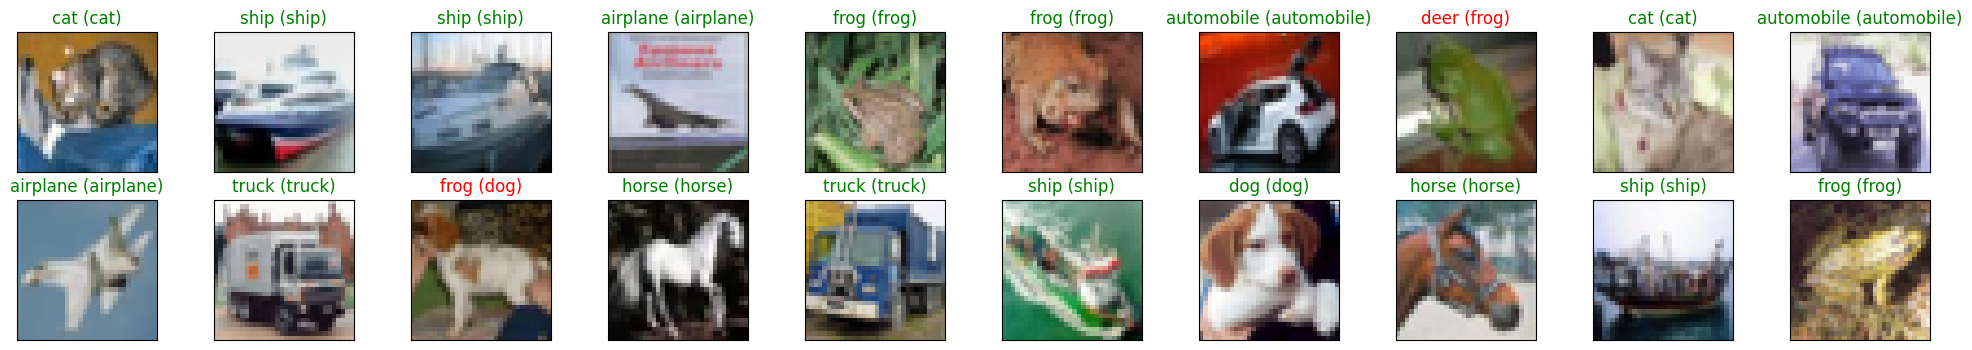

In [43]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.__next__()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model2(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# move images back to cpu
images = images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

Great job! You have successfully trained a convolutional neural network on the CIFAR-10 dataset.